In [264]:
import datascience as ds
from datascience import *
import numpy as np
from graphviz import Source
import pandas as pd
import re
import string
from copy import copy
import nltk
import datetime

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBoostClassifier
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from imblearn.over_sampling import SMOTE

import gensim
%matplotlib inline

In [145]:
tagged = pd.read_csv('cleaned_tagged.csv', sep=',')
Relevant = np.array([0]*tagged.size)
Relevant[tagged[tagged.sentiment!=-1].index.tolist()] = 1
tagged['Relevant'] = pd.Series(Relevant, name='Relevant')
tagged = tagged.drop(tagged.columns[0], axis=1).reset_index(drop=True)
tagged

,user_id,user_name,tweet_time,location,text,sentiment,Relevant
0,802657195661742080,Christine Warren,Wed Sep 12 01:38:14 +0000 2018,Fremont CA,2 american lives were just lost in tennessee p...,0,1
1,1039245812230893570,Trumpservative,Wed Sep 12 01:38:16 +0000 2018,Tulsa OK,realfarmacist realdonaldtrump tuckercarlson ou...,1,1
2,282084840,Darrel Sheldon #MAGAVETERAN,Wed Sep 12 01:38:18 +0000 2018,None,rightgottweets rev out the trumptrain for blue...,0,1
3,62315639,Queer Liberal Voting Snowflake,Wed Sep 12 01:38:18 +0000 2018,Big Sandy Texas,tennessee is suffering after shooting takes 2 ...,0,1
4,823307049266245633,don jones #veteran (K),Wed Sep 12 01:38:19 +0000 2018,United States,sassytjoy bcmsolt fightinirish109 dybarb wolfi...,-1,0
5,340428574,DelcoGal,Wed Sep 12 01:38:21 +0000 2018,Pennsylvania,loudobbs redwaverising sidneypowell1 this year...,1,1
6,1603928228,Julz,Wed Sep 12 01:38:22 +0000 2018,MIAATLPGH,2 lives were just lost in tennessee potus its ...,0,1
7,1865678516,Barbara Kuczinski,Wed Sep 12 01:38:22 +0000 2018,None,mollympengra realjameswoods obama mollympengra...,1,1
8,59288409,Josh Steed PhD,Wed Sep 12 01:38:25 +0000 2018,Arkansas,jillibean557 msm is repulsive they do nothing ...,0,1
9,325172419,Mrs. Linz,Wed Sep 12 01:38:25 +0000 2018,BC Canada,jc61384960 loricoutler amymek muslims coming i...,2,1


In [240]:
relevant_idx = tagged[tagged.Relevant==1].index
irrelevant_idx = tagged[tagged.Relevant==0].index

In [242]:
def undersample(relevant_idx, irrelevant_idx, percentage, vector):
    undersample_relevant_idx = np.array(np.random.choice(relevant_idx,(int(percentage*len(irrelevant_idx))),replace=False))
    undersample_idx= np.concatenate([irrelevant_idx, undersample_relevant_idx])
    undersample_data = tagged.iloc[undersample_idx,:]
    print('There are {} relevant tweets.\n There are {} irrelevant tweets.'.format(len(undersample_data[undersample_data.Relevant==1]), 
                                                                                   len(undersample_data[undersample_data.Relevant==0])))
    X_train, X_test, y_train, y_test = train_test_split(undersample_data.text, undersample_data.Relevant, test_size=0.2, random_state=100)
    X_train_vect = vector.fit_transform(X_train).todense()
    X_test_vect = vector.transform(X_test)
    plt.figure(figsize=(5,5))
    sns.countplot("Relevant",data=undersample_data)
    plt.show()
    return X_train_vect, X_test_vect, y_train, y_test

In [243]:
def oversample(data, vector):
    os = SMOTE(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(data.text, data.Relevant, test_size=0.2, random_state=100)
    X_train_vect = vector.fit_transform(X_train).todense()
    X_test_vect = vector.transform(X_test)
    os_X_train, os_y_train = os.fit_sample(X_train_vect, y_train)
    return os_X_train, X_test_vect, os_y_train, y_test

In [244]:
def plot_cm(cm, title='Confusion matrix', cmap=plt.cm.Blues, classes=['Relevant', 'Irrelevant']):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    target_names = classes
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [266]:
def classify(X_train_vect, y_train, X_test_vect, y_test, model, vector):
    clf.fit(X_train_vect, y_train)
    y_pred = clf.predict(X_test_vect)
    try:
        dot_data = tree.export_graphviz(model, out_file=None, feature_names=vector.get_feature_names())
        graph = Source(dot_data)
        graph.render('RelevantClassifier_{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
    except Exception as e:
        print(e)
    cross_val_s = np.mean([cross_val_score(model, X_train_vect, y_train, cv=8)])
    print('Cross_val_score: {}'.format(cross_val_s))
    print("AUC(ROC): " + str(metrics.roc_auc_score(y_test, y_pred)))
    print("Precision: " + str(metrics.precision_score(y_test, y_pred)))
    print("Recall: " + str(metrics.recall_score(y_test, y_pred)))
    print("F1 score: " + str(metrics.f1_score(y_test, y_pred)))
    print(metrics.confusion_matrix(y_test, y_pred))
    plt.figure(figsize=(5,5))
    plot_cm(metrics.confusion_matrix(y_test, y_pred))
    plt.show()
    return cross_val_s

In [267]:
vect = CountVectorizer(
     analyzer="word", ngram_range=([1,2]), tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000)
# vect = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l1', encoding='latin-1', 
#                         ngram_range=(1,2), stop_words='english')

In [268]:
clf = DecisionTreeClassifier(criterion = 'entropy',
                            random_state = 100,
                            max_depth = 15,
                            min_samples_leaf = 2)
# clf = RandomForestClassifier(random_state=100,
#                              n_estimators=15, 
#                              criterion='entropy', 
#                              n_jobs=4)
# clf = XGBoostClassifier(max_depth=5, n_estimators=10)
# clf = LogisticRegression()

There are 163 relevant tweets.
 There are 163 irrelevant tweets.


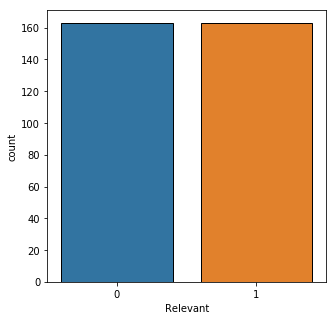

Cross_val_score: 0.8578209005376344
AUC(ROC): 0.8327067669172933
Precision: 0.9333333333333333
Recall: 0.7368421052631579
F1 score: 0.8235294117647058
[[26  2]
 [10 28]]


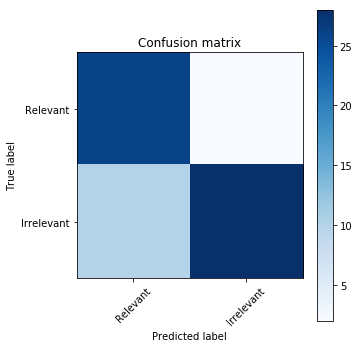

There are 244 relevant tweets.
 There are 163 irrelevant tweets.


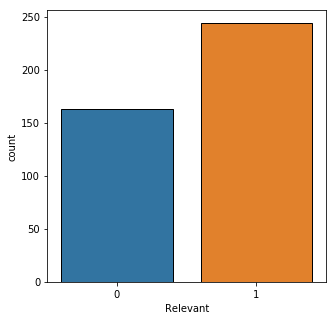

Cross_val_score: 0.8428001876172608
AUC(ROC): 0.8490566037735849
Precision: 1.0
Recall: 0.6981132075471698
F1 score: 0.8222222222222222
[[29  0]
 [16 37]]


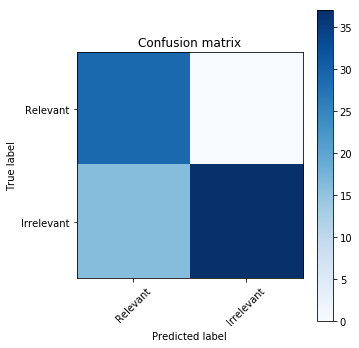

There are 326 relevant tweets.
 There are 163 irrelevant tweets.


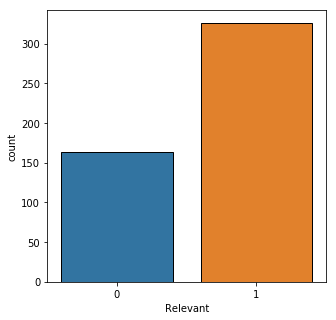

Cross_val_score: 0.8238818027210884
AUC(ROC): 0.8436274509803922
Precision: 0.98
Recall: 0.7205882352941176
F1 score: 0.8305084745762712
[[29  1]
 [19 49]]


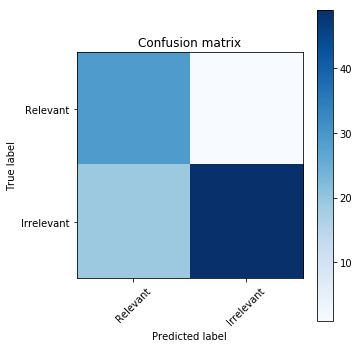

There are 407 relevant tweets.
 There are 163 irrelevant tweets.


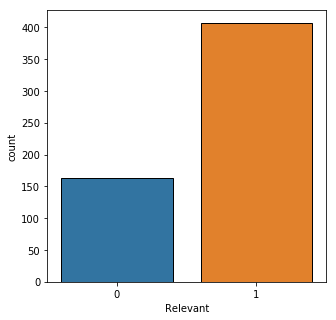

Cross_val_score: 0.7982604679802956
AUC(ROC): 0.8513408472600078
Precision: 0.9838709677419355
Recall: 0.7349397590361446
F1 score: 0.8413793103448276
[[30  1]
 [22 61]]


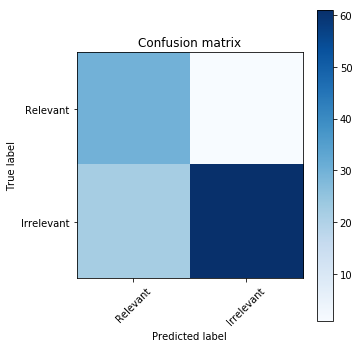

There are 489 relevant tweets.
 There are 163 irrelevant tweets.


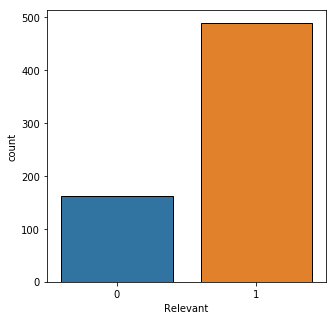

Cross_val_score: 0.8156850961538461
AUC(ROC): 0.8737373737373737
Precision: 1.0
Recall: 0.7474747474747475
F1 score: 0.8554913294797689
[[32  0]
 [25 74]]


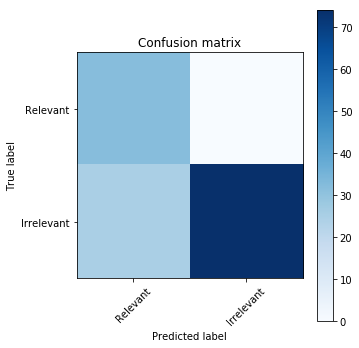

There are 570 relevant tweets.
 There are 163 irrelevant tweets.


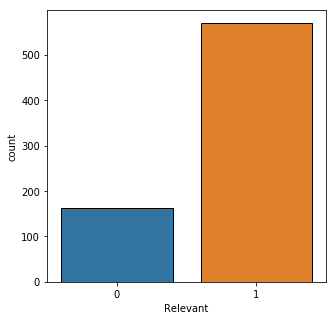

Cross_val_score: 0.7971411051462421
AUC(ROC): 0.7912776412776412
Precision: 0.9605263157894737
Recall: 0.6636363636363637
F1 score: 0.7849462365591398
[[34  3]
 [37 73]]


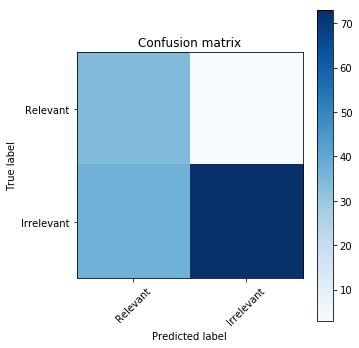

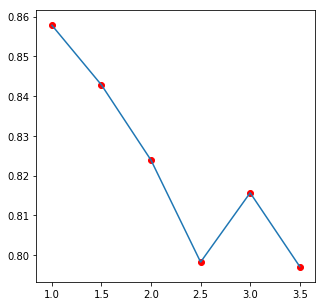

In [273]:
cross_val_scores=[]
for percentage in np.arange(1, 4, 0.5):
    X_train_vect, X_test_vect, y_train, y_test = undersample(relevant_idx, irrelevant_idx, percentage, vect)
    cross_val_s = classify(X_train_vect=X_train_vect,
        X_test_vect=X_test_vect,
        y_train =y_train,
        y_test=y_test,
        model=clf,
        vector=vect)
    cross_val_scores.append(cross_val_s)
plt.figure(figsize=(5,5))
plt.plot(np.arange(1,4,0.5), cross_val_scores)
plt.scatter(np.arange(1,4,0.5), cross_val_scores, c='r')
plt.show()

cross_val_score: 0.8636032836516069
[[ 27   5]
 [ 57 171]]


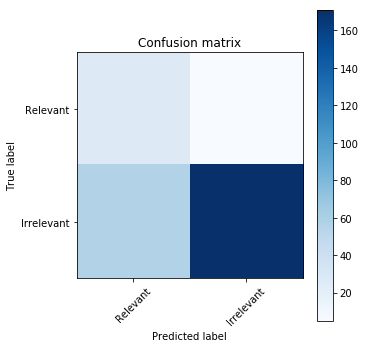

0.8636032836516069

In [235]:
X_train_vect, X_test_vect, y_train, y_test = oversample(tagged, vect)
cross_val_s = classify(X_train_vect=X_train_vect,
        X_test_vect=X_test_vect,
        y_train =y_train,
        y_test=y_test,
        model=clf,
        vector=vect)
cross_val_s

### AutoEncoder

In [258]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [259]:
first_test = int(tagged.shape[0] * (1 - 0.3))
first_val = int(first_test * (1 - 0.2))

train = tagged.iloc[:first_val]
val = tagged.iloc[first_val:first_test]
test = tagged.iloc[first_test:]

x_train_df, x_val_df, x_test_df = train.iloc[:, -3], val.iloc[:, -3], test.iloc[:, -3]
y_train_df, y_val_df, y_test_df = train.iloc[:, -1], val.iloc[:, -1], test.iloc[:, -1]

x_train_df.head(), y_train_df.head()

(0    2 american lives were just lost in tennessee p...
 1    realfarmacist realdonaldtrump tuckercarlson ou...
 2    rightgottweets rev out the trumptrain for blue...
 3    tennessee is suffering after shooting takes 2 ...
 4    sassytjoy bcmsolt fightinirish109 dybarb wolfi...
 Name: text, dtype: object, 0    1
 1    1
 2    1
 3    1
 4    0
 Name: Relevant, dtype: int64)

In [271]:
x_train, x_val, x_test = x_train_df.values, x_val_df.values, x_test_df.values
y_train, y_val, y_test = y_train_df.values, y_val_df.values, y_test_df.values


vect = CountVectorizer(
     analyzer="word", ngram_range=([1,2]), tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000)

x_train, x_val, x_test = vect.fit_transform(x_train), vect.transform(x_val), vect.transform(x_test)
x_train.shape, x_val.shape, x_test.shape

((725, 3000), (182, 3000), (389, 3000))

In [272]:
class VAEencoder():
    def __init__(self, 
                hidden_size,
                latent_dim):
        self.hidden_size = 16 
        self.latent_dim = 2 
        self.n_epochs = 30
        self.batch_size = 128

        self.input_dim = x_train.shape[1]

        self.x = Input(shape=(input_dim,))
        self.t = BatchNormalization()(self.x)
        self.t = Dense(hidden_size, activation='tanh' , name='encoder_hidden')(self.t)
        self.t = BatchNormalization()(self.t)

        z_mean = Dense(latent_dim, name='z_mean')(t)
        z_log_var = Dense(latent_dim, name='z_log_var')(t)
        
        z = Lambda(sampling, name='z_sampled')([z_mean, z_log_var])
        #t = BatchNormalization()(z)

        t = Dense(hidden_size, activation='tanh', name='decoder_hidden')(z)
        #t = BatchNormalization()(t)

        decoded_mean = Dense(input_dim, activation=None, name='decoded_mean')(t)

        vae = Model(x, decoded_mean)
        vae.compile(optimizer=Adam(lr=1e-2), loss=vae_loss, metrics=[rec_loss, kl_loss])
        vae.summary()
    
        early_stopping = EarlyStopping(monitor='loss', patience=10) #stop training if loss does not decrease with at least 0.00001
        reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.2) #reduce learning rate (divide it by 5 = multiply it by 0.2) if loss does not decrease with at least 0.00001

        callbacks = [early_stopping, reduce_lr]

        history = vae.fit(x_train, x_train, 
                          validation_data=(x_val, x_val), 
                          batch_size=batch_size, epochs=n_epochs, 
                          callbacks=callbacks)
        
        encoder = Model(x, z_mean)
        
        fig = plt.figure(figsize=(14, 6))
        ax = fig.gca()
        ax.plot(history.history['rec_loss'], c='r');
        ax.plot(history.history['val_rec_loss']);
        
    def fit():
        return NotImplemented
    
    def predict():
        return NotImplemented
        

    def sampling(self, args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
        return z_mean + K.exp(z_log_var / 2) * epsilon


    def rec_loss(self, y_true, y_pred):
        return K.sum(K.square(y_true - y_pred), axis=-1)

    def kl_loss(self, y_true, y_pred):
        return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    def vae_loss(self, x, decoded_mean):
        rec_loss = K.sum(K.square(x - decoded_mean), axis=-1)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean((rec_loss + kl_loss) / 2)